In [1]:
# joblib.dump(model, 'model_14_12_10_59.pkl')
# model = joblib.load('model.pkl')

In [2]:
from codes import *

[nltk_data] Downloading package wordnet to /home/damian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Concatenate, Input, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import joblib
import matplotlib.pyplot as plt

2023-12-19 15:52:51.201419: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 15:52:51.227937: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 15:52:51.325107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 15:52:51.325146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 15:52:51.339862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
# prepareCorpus(tolower=True, _stemming=False, _lemmatizing=True, dataFolder='./data/', max_features=5000)

In [5]:
df = joblib.load('./data/TfidfDataframe.pkl')

In [6]:
X1 = np.array(df['tfidf1'])
X2 = np.array(df['tfidf2'])
y = np.array(df['is_duplicate'])

In [7]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [8]:
def data_generator(X1, X2, y, batch_size, epochs):
    num_samples = X1.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    for epoch in range(epochs):
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
    
            batch_indices = np.arange(start_idx, end_idx)
            X1_batch_sparse = X1[batch_indices]
            X2_batch_sparse = X2[batch_indices]

            X1_batch_dense = np.vstack([convert_to_dense(x) for x in X1_batch_sparse])
            X2_batch_dense = np.vstack([convert_to_dense(x) for x in X2_batch_sparse])

            y_batch = y[batch_indices]
            
            yield [X1_batch_dense, X2_batch_dense], y_batch

def convert_to_dense(sparse_vector):
    return sparse_vector.toarray().flatten()

In [30]:
input_1 = Input(shape=(5000,))
input_2 = Input(shape=(5000,))

branch_1 = Dense(1024, activation='relu')(input_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = Dropout(0.5)(branch_1)
branch_1 = Dense(512, activation='relu')(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = Dropout(0.5)(branch_1)
branch_1 = Dense(512, activation='relu')(branch_1)

branch_2 = Dense(1024, activation='relu')(input_2)
branch_2 = BatchNormalization()(branch_2)
branch_2 = Dropout(0.5)(branch_2)
branch_2 = Dense(512, activation='relu')(branch_2)
branch_2 = BatchNormalization()(branch_2)
branch_2 = Dropout(0.5)(branch_2)
branch_2 = Dense(512, activation='relu')(branch_2)

merged = Concatenate()([branch_1, branch_2])

merged = Dense(1024, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
merged = Dense(512, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
merged = Dense(512, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
merged = Dense(512, activation='relu')(merged)

output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_1, input_2], outputs=output)

In [31]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 5000)]               0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 5000)]               0         []                            
                                                                                                  
 dense_44 (Dense)            (None, 1024)                 5121024   ['input_9[0][0]']             
                                                                                                  
 dense_47 (Dense)            (None, 1024)                 5121024   ['input_10[0][0]']            
                                                                                            

In [33]:
batch_size = 1024
epochs = 20

train_generator = data_generator(X1_train, X2_train, y_train, batch_size, epochs)
validation_generator = data_generator(X1_test, X2_test, y_test, batch_size, epochs)

steps_per_epoch = int(np.ceil(X1_train.shape[0] / batch_size))
validation_steps = int(np.ceil(X1_test.shape[0] / batch_size))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [34]:
# history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])

history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps)

Epoch 1/20
316/316 [==============================] - 162s 507ms/step - loss: 0.5984 - accuracy: 0.6922 - val_loss: 0.6701 - val_accuracy: 0.6283
Epoch 2/20
316/316 [==============================] - 176s 558ms/step - loss: 0.4980 - accuracy: 0.7611 - val_loss: 0.6010 - val_accuracy: 0.6516
Epoch 3/20
316/316 [==============================] - 167s 529ms/step - loss: 0.4457 - accuracy: 0.7933 - val_loss: 0.5339 - val_accuracy: 0.7399
Epoch 4/20
316/316 [==============================] - 164s 519ms/step - loss: 0.3910 - accuracy: 0.8232 - val_loss: 0.6607 - val_accuracy: 0.7492
Epoch 5/20
316/316 [==============================] - 155s 489ms/step - loss: 0.3343 - accuracy: 0.8525 - val_loss: 0.7414 - val_accuracy: 0.7709
Epoch 6/20
316/316 [==============================] - 156s 494ms/step - loss: 0.2807 - accuracy: 0.8776 - val_loss: 0.7697 - val_accuracy: 0.7807
Epoch 7/20
316/316 [==============================] - 163s 517ms/step - loss: 0.2381 - accuracy: 0.8978 - val_loss: 0.7245 -

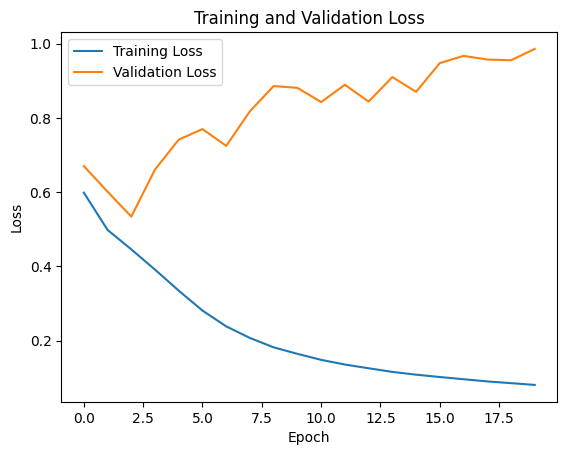

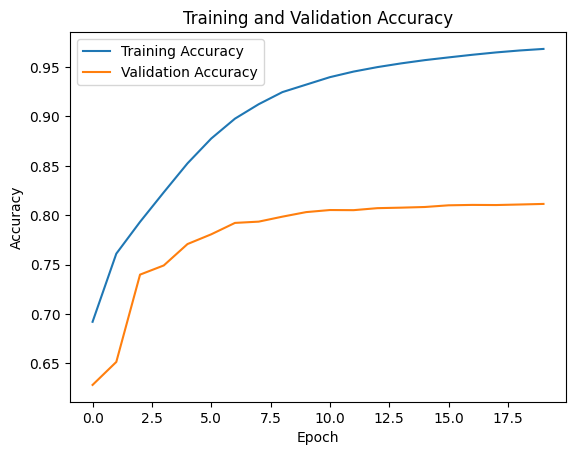

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

79/79 [==============================] - 14s 174ms/step
Accuracy: 0.8105196764698608
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86     50803
           1       0.80      0.65      0.72     30055

    accuracy                           0.81     80858
   macro avg       0.81      0.78      0.79     80858
weighted avg       0.81      0.81      0.81     80858



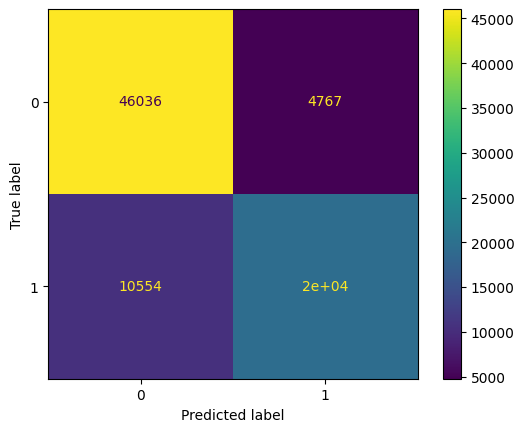

In [36]:
validation_generator = data_generator(X1_test, X2_test, y_test, batch_size, epochs)
y_pred_prob = model.predict(validation_generator, steps=validation_steps)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()